In [1]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image
import torch
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import models
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from collections import Counter
import albumentations as A

scene_dict_file = open('scene_dict.json','r')
scene_dict = json.load(scene_dict_file)
s_by_i = {int(i):key for i,key in scene_dict[0].items()}
i_by_s = {key:int(i) for key,i in scene_dict[1].items()}
train_folder = 'drivedata/train/'
test_folder = 'drivedata/test_scene/'
print(s_by_i)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
print(torch.cuda.get_device_name(0))


{0: 'city street', 1: 'residential', 2: 'highway', 3: 'parking lot', 4: 'tunnel', 5: 'gas stations', 6: 'dirt road', 7: 'countryside'}
GeForce RTX 2060


In [2]:
class SceneDataset(Dataset):
    def __init__(self, folder, transform=None, augmentation=None):
        self.transform = transform
        self.augmentation=augmentation
        self.folder = folder
        filenames = os.listdir(self.folder)
        self.filenames = [name for name in filenames if name != 'desktop.ini'and name.split('_')[1]!='undefined']
        splited = [x.replace('.jpg','').split('_') for x in self.filenames]
        self.splited = [[i_by_s[x[1]],x[0]] for x in splited]
        self.transform = transform
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.folder, self.filenames[index]))
        y = self.splited[index][0]
        name = self.filenames[index]
        if self.augmentation:
            img = self.augmentation(image = np.array(img))['image']
        if self.transform: 
            img = self.transform(img)
        return img, y, name

In [3]:
def init_aug():
    augmentation_pipeline = A.Compose(
    [
        A.ShiftScaleRotate(rotate_limit=10),
        A.HorizontalFlip(p = 0.5), # apply horizontal flip to 50% of images
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(), # apply random contrast
                A.RandomGamma(), # apply random gamma
                A.RandomBrightness(), # apply random brightness
            ],
            p = 0.5
        ),
    ],
    p = 1
    )
    return augmentation_pipeline

In [4]:
def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices): 
        x, y, _ = dataset[index]
        #trans = transforms.ToPILImage()
        #x = trans(x)
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   

In [15]:
orig_dataset = SceneDataset('drivedata/train/',augmentation=init_aug())


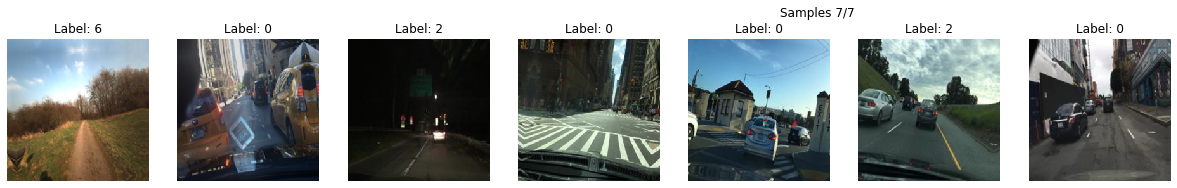

In [87]:
np.random.seed(42)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

In [5]:
train_dataset = SceneDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ]),
                        augmentation=init_aug()
                      )
test_dataset =SceneDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

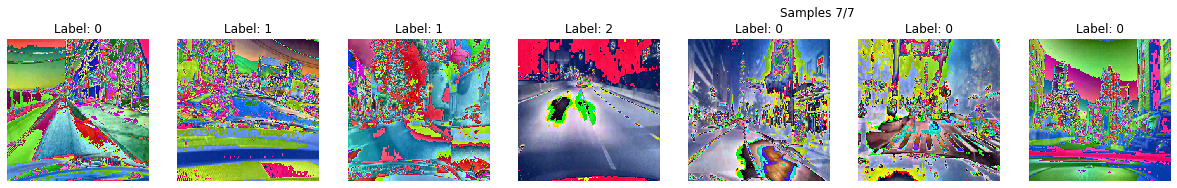

In [7]:
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)
visualize_samples(train_dataset, indices, "Samples" )

In [6]:
batch_size = 16
data_size = len(train_dataset)
validation_fraction = .1
val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)
val_indices, train_indices = indices[:val_split], indices[val_split:]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler,pin_memory=True,num_workers=4)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,pin_memory=True)


In [7]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        start = time.time()
        for i_step, (x, y,_) in enumerate(train_loader):
            start = time.time()
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            print(i_step,  time.time()- start)
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val balanced accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    pred = list()
    gr_tr = list()
    for (x,y,_) in loader:
        x = x.to(device=device)
        y = y.to(device=device)
        predict = model(x)
        x.cpu()
        _, indices = torch.max(predict, 1)
        gr_tr.extend(y.cpu().tolist())
        pred.extend(indices.cpu().tolist())
        
    val_accuracy = metrics.classification_report(gr_tr, pred, target_names=list(i_by_s.keys()))
    return [gr_tr,pred]

In [17]:
model = torch.load('models_checkpoint/scene_2020-02-24_19-02_1_0.8830429491073316.pt')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [16]:
num_ftrs = model.fc
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [12]:
parameters = model.parameters()
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD([{'params': model.fc.parameters(), 'lr': 1e-3},
                    {'params': list(model.parameters())[:-2]}],
                     lr=0.0001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

BrokenPipeError: [Errno 32] Broken pipe

In [5]:
result_file = open('val_result.json','r')
result = json.load(result_file)
pred = np.array(result[0])
gr_tr = np.array(result[1])

In [6]:
print(metrics.classification_report(gr_tr,pred,target_names=i_by_s.keys()))

              precision    recall  f1-score   support

 city street       0.80      0.86      0.83      5340
 residential       0.73      0.67      0.70      1770
     highway       0.80      0.70      0.75      2256
 parking lot       0.85      0.92      0.88       162
      tunnel       0.79      0.71      0.75        31
gas stations       0.94      0.94      0.94        63
   dirt road       1.00      1.00      1.00       896
 countryside       0.97      0.96      0.96       318

    accuracy                           0.81     10836
   macro avg       0.86      0.84      0.85     10836
weighted avg       0.81      0.81      0.81     10836



In [ ]:
pred =pred+1
gr_tr = gr_tr+1

In [18]:
print(pred.shape,gr_tr.shape)

(9521,) (9521,)


In [13]:
metrics.f1_score(gr_tr,pred,average='micro')

0.7873122571158491

In [20]:
print(Counter(gr_tr))

Counter({1: 4729, 3: 1861, 2: 1739, 7: 911, 4: 182, 6: 69, 5: 30})


In [21]:
correct = gr_tr==pred

In [22]:
gr_tr_pr = gr_tr * correct

In [23]:
print(Counter(gr_tr_pr))

Counter({1: 3595, 0: 2178, 3: 1516, 2: 1107, 7: 911, 4: 137, 6: 61, 5: 16})


              precision    recall  f1-score   support

           1       0.81      0.76      0.79      4729
           2       0.74      0.64      0.68      1739
           3       0.63      0.81      0.71      1861
           4       0.67      0.75      0.71       182
           5       1.00      0.53      0.70        30
           6       0.91      0.88      0.90        69
           7       1.00      1.00      1.00       911

    accuracy                           0.77      9521
   macro avg       0.82      0.77      0.78      9521
weighted avg       0.78      0.77      0.77      9521



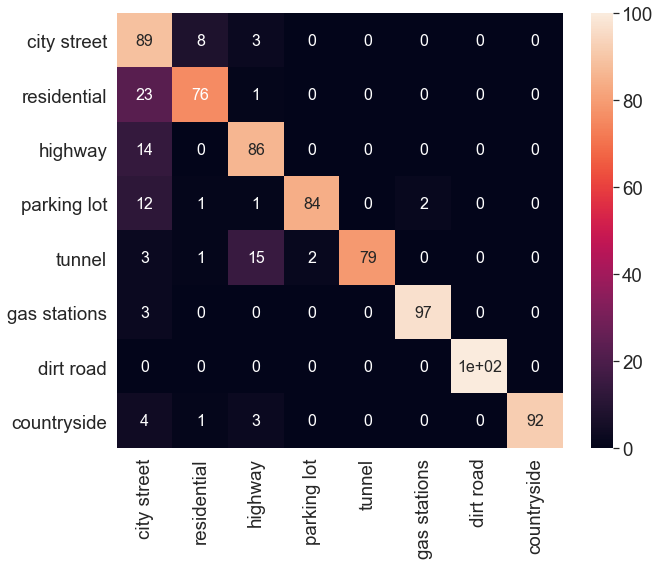

In [20]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = metrics.confusion_matrix(gr_tr,pred)

df_cm = pd.DataFrame(array,list(i_by_s.keys()), list(i_by_s.keys()))
plt.figure(figsize=(10,8))
sn.set(font_scale=1.7) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [18]:
[gr_tr, pred] = compute_accuracy(model,test_loader)
#errors = compute_test_metrics(model,test_loader)


In [21]:
print(metrics.classification_report(gr_tr,pred,target_names=list(i_by_s.keys())))

              precision    recall  f1-score   support

 city street       0.60      0.89      0.72       100
 residential       0.87      0.76      0.81       100
     highway       0.79      0.86      0.82       100
 parking lot       0.98      0.84      0.90       100
      tunnel       1.00      0.79      0.88       100
gas stations       0.98      0.97      0.97       100
   dirt road       1.00      1.00      1.00       100
 countryside       1.00      0.92      0.96       100

    accuracy                           0.88       800
   macro avg       0.90      0.88      0.88       800
weighted avg       0.90      0.88      0.88       800



In [12]:
def compute_test_metrics(model,loader):
    model.eval() # Evaluation mode
    pred = list()
    gr_tr = list()
    images = []
    errors = []
    toPILL = transforms.ToPILImage()
    for (x,y,name) in loader:
        x = x.to(device=device)
        y = y.to(device=device)
        predict = model(x)
        _, indices = torch.max(predict, 1)
        y = y.cpu().tolist()
        indices = indices.cpu().tolist()
        gr_tr.extend(y)
        pred.extend(indices)
        errors_temp = [{'image':name[i],'gr_tr':s_by_i[y[i]],"pred":s_by_i[indices[i]]} for i in range(len(y)) if y[i]!=indices[i]]
        errors.extend(errors_temp)
    return errors

In [ ]:
count = len(errors)
i = 0
for error in errors:
    i+=1
    img = Image.open(os.path.join('drivedata/test_scene',error['image']))
    print('gr_tr: %s pred: %s'% (error['gr_tr'],error['pred']), end="\r")
    img.show()
    input()
